In [14]:
import os
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, decimate, resample
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [15]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [17]:
def extract_epochs(eeg_data, start_times, fs, epoch_duration=800, target_fs=125):
    n_samples = int((epoch_duration / 1000) * fs)
    n_samples_target = int((epoch_duration / 1000) * target_fs)
    epochs = []
    for start_time in start_times:
        start_sample = int(start_time * fs)
        end_sample = start_sample + n_samples
        segment = eeg_data.iloc[start_sample:end_sample]

        resampled_segments = np.zeros((n_samples_target, segment.shape[1]))
        for channel_index in range(segment.shape[1]):
            resampled_segments[:, channel_index] = resample(segment.iloc[:, channel_index], n_samples_target)

        # Apply bandpass filter
        filtered_segments = np.apply_along_axis(butter_bandpass_filter, 0, resampled_segments, 1, 10, target_fs)

        # Normalize to zero mean
        normalized_segments = filtered_segments - np.mean(filtered_segments, axis=0)
        epochs.append(normalized_segments)

    return np.array(epochs)

In [18]:
def process_eeg_file(file_path, sampling_rate):
    eeg_data = pd.read_csv(file_path)
    feedback_start_times = eeg_data[eeg_data['FeedBackEvent'] == 1]['Time']
    return extract_epochs(eeg_data.iloc[:, 1:-2], feedback_start_times, sampling_rate)

In [19]:
def format_id(feedback_id):
    parts = feedback_id.split('_')
    new_id = "Data_" + '_'.join(parts[:2])
    return new_id

def aggregate_datasets(labels_file_path, eeg_files_folder, fs):
    labels_data = pd.read_csv(labels_file_path)
    all_epochs = []
    all_labels = []
    last_processed_file_name = ""
    
    for _, row in labels_data.iterrows():
        eeg_file_name = format_id(row['IdFeedBack'])
        feedback_type = row['Prediction']
        eeg_file_path = os.path.join(eeg_files_folder, eeg_file_name + '.csv')
        
        if eeg_file_name != last_processed_file_name:
            if os.path.exists(eeg_file_path):
                print(f"Processing: {eeg_file_name}")
                epochs = process_eeg_file(eeg_file_path, fs)
                all_epochs.append(epochs)
                last_processed_file_name = eeg_file_name
        
        all_labels.append(feedback_type) 

    return np.vstack(all_epochs), np.array(all_labels)

In [20]:
fs = 200
labels_file_path = '/home/administrator/BCI/data/kaggle_errp/TrainLabels.csv'
eeg_files_folder = '/home/administrator/BCI/data/kaggle_errp/train/'
X, y = aggregate_datasets(labels_file_path, eeg_files_folder, fs)

Processing: Data_S02_Sess01
Processing: Data_S02_Sess02
Processing: Data_S02_Sess03
Processing: Data_S02_Sess04
Processing: Data_S02_Sess05
Processing: Data_S06_Sess01
Processing: Data_S06_Sess02
Processing: Data_S06_Sess03
Processing: Data_S06_Sess04
Processing: Data_S06_Sess05
Processing: Data_S07_Sess01
Processing: Data_S07_Sess02
Processing: Data_S07_Sess03
Processing: Data_S07_Sess04
Processing: Data_S07_Sess05
Processing: Data_S11_Sess01
Processing: Data_S11_Sess02
Processing: Data_S11_Sess03
Processing: Data_S11_Sess04
Processing: Data_S11_Sess05
Processing: Data_S12_Sess01
Processing: Data_S12_Sess02
Processing: Data_S12_Sess03
Processing: Data_S12_Sess04
Processing: Data_S12_Sess05
Processing: Data_S13_Sess01
Processing: Data_S13_Sess02
Processing: Data_S13_Sess03
Processing: Data_S13_Sess04
Processing: Data_S13_Sess05
Processing: Data_S14_Sess01
Processing: Data_S14_Sess02
Processing: Data_S14_Sess03
Processing: Data_S14_Sess04
Processing: Data_S14_Sess05
Processing: Data_S16

In [21]:
X.shape

(5440, 100, 56)

In [22]:
y.shape

(5440,)

In [23]:
y

array([1, 1, 0, ..., 0, 0, 1])

In [24]:
import numpy as np
from collections import Counter
from sklearn.utils import resample

print("Original class distribution:", Counter(y))

min_class_size = np.min([np.sum(y == cl) for cl in np.unique(y)])

X_undersampled = []
y_undersampled = []

for cl in np.unique(y):
    class_indices = np.where(y == cl)[0]
    
    undersample_indices = resample(class_indices, replace=False, n_samples=min_class_size, random_state=42)
    
    X_undersampled.append(X[undersample_indices])
    y_undersampled.append(y[undersample_indices])

X_undersampled = np.vstack(X_undersampled)
y_undersampled = np.concatenate(y_undersampled)

print("New class distribution:", Counter(y_undersampled))

Original class distribution: Counter({1: 3850, 0: 1590})
New class distribution: Counter({0: 1590, 1: 1590})


In [25]:
X_undersampled.shape

(3180, 100, 56)

In [26]:
print(y_undersampled)

[0 0 0 ... 1 1 1]


In [37]:
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.signal import resample
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

channel_indices = [0, 1, 6, 8, 12, 14, 24, 26, 30, 32, 42, 44, 48, 50, 54, 55]

X_selected_channels = X_undersampled[:, :, channel_indices]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected_channels.reshape(-1, X_selected_channels.shape[-1])).reshape(X_selected_channels.shape)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_undersampled, test_size=0.2, random_state=42, stratify=y_undersampled)

model = Sequential([
    LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=30, batch_size=64)

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/30
40/40 [==============================] - 5s 66ms/step - loss: 0.7351 - accuracy: 0.5122
Epoch 2/30
40/40 [==============================] - 2s 62ms/step - loss: 0.7185 - accuracy: 0.4961
Epoch 3/30
40/40 [==============================] - 2s 58ms/step - loss: 0.7091 - accuracy: 0.5197
Epoch 4/30
40/40 [==============================] - 3s 66ms/step - loss: 0.6956 - accuracy: 0.5338
Epoch 5/30
40/40 [==============================] - 3s 76ms/step - loss: 0.6882 - accuracy: 0.5645
Epoch 6/30
40/40 [==============================] - 4s 93ms/step - loss: 0.6848 - accuracy: 0.5802
Epoch 7/30
40/40 [==============================] - 3s 78ms/step - loss: 0.6771 - accuracy: 0.5825
Epoch 8/30
40/40 [==============================] - 3s 77ms/step - loss: 0.6681 - accuracy: 0.5998
Epoch 9/30
40/40 [==============================] - 3s 75ms/step - loss: 0.6521 - accuracy: 0.6285
Epoch 10/30
40/40 [==============================] - 3s 71ms/step - loss: 0.6487 - accuracy: 0.6152
Epoch 11/

In [38]:
import joblib

joblib.dump(model, "lstm_errp_under.pkl")

['lstm_errp_under.pkl']

In [39]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_pred_probs = model.predict(X_test)

y_pred = (y_pred_probs > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

print(f'Test Accuracy: {accuracy:.2f}')

20/20 [==============================] - 1s 16ms/step
Confusion Matrix:
[[217 101]
 [111 207]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.66      0.68      0.67       318
     Class 1       0.67      0.65      0.66       318

    accuracy                           0.67       636
   macro avg       0.67      0.67      0.67       636
weighted avg       0.67      0.67      0.67       636

Test Accuracy: 0.67


In [40]:
X_selected_channels[0, :, :].shape

(100, 16)

In [41]:
segment = X_selected_channels[3, :, :]

segment_scaled = scaler.transform(segment.reshape(-1, 16)).reshape(1, 100, 16)

prediction = model.predict(segment_scaled)
print("Prediction for the segment:", prediction)

1/1 [==============================] - 0s 25ms/step
Prediction for the segment: [[0.31907555]]


In [18]:
X_undersampled[:,:,0].shape

(3180, 100)

In [19]:
len(y_undersampled)

3180

Test Set Balanced Accuracy: 0.5941783367525941

Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.60      0.61       333
           1       0.57      0.59      0.58       303

    accuracy                           0.59       636
   macro avg       0.59      0.59      0.59       636
weighted avg       0.60      0.59      0.59       636



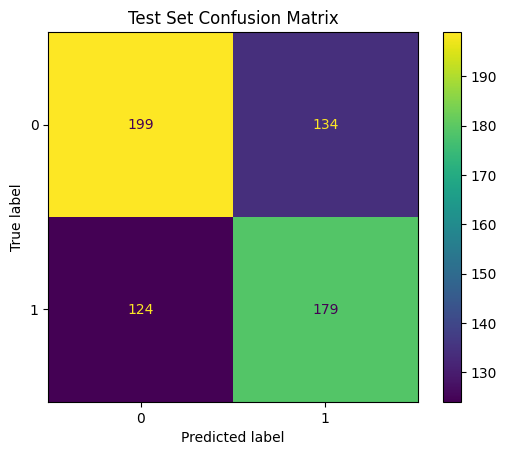

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

X = X_undersampled[:,:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y_undersampled, test_size=0.2, random_state=42)

X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

clf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None,
    random_state=42
)
clf.fit(X_train_flattened, y_train)

y_test_pred = clf.predict(X_test_flattened)
test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
print(f"Test Set Balanced Accuracy:", test_balanced_accuracy)
print(f"\nTest Set Classification Report:\n", classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()
plt.title(f'Test Set Confusion Matrix')
plt.show()

In [21]:
import joblib

joblib.dump(clf, "rf_errp_under.pkl")

['rf_errp_under.pkl']

Accuracy: 0.56


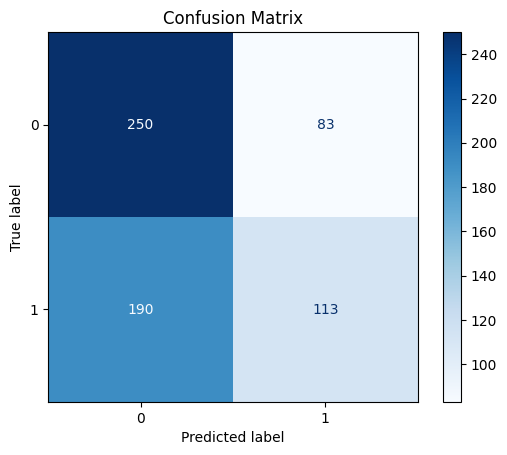

              precision    recall  f1-score   support

           0       0.57      0.75      0.65       333
           1       0.58      0.37      0.45       303

    accuracy                           0.57       636
   macro avg       0.57      0.56      0.55       636
weighted avg       0.57      0.57      0.55       636



In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import joblib
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

X = X_undersampled[:,:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y_undersampled, test_size=0.2, random_state=42)

X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

svm_classifier = SVC(kernel='rbf', C=20, degree=30)

svm_classifier.fit(X_train_flattened, y_train)

y_pred = svm_classifier.predict(X_test)

accuracy = balanced_accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))